In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

import xgboost as xgb


In [10]:
# Preprocessing function
def preprocess_data(file_path):
    # Load the data
    df = pd.read_excel(file_path)
    
    # Ensure that 'Text' column is used as the independent variable
    df['Text'] = df['Text'].astype(str)
    
    # Drop any rows where 'Text' or 'Type' is NaN
    df.dropna(subset=['Text', 'Type'], inplace=True)
    
    # Define features and labels
    X = df['Text']
    y = df['Type']
    
    # Encode the labels into numeric values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Preprocess the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X)
    
    # Split the data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

# Load and preprocess data
file_path = 'test.xlsx'
X_train, X_test, y_train, y_test, label_encoder = preprocess_data(file_path)

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, label_encoder, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Best Hyperparameters found by RandomizedSearchCV: {'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': 1, 'C': 0.46415888336127775}
Results for SVM after Randomized Hyperparameter Tuning:
Training Accuracy: 0.8452
Test Accuracy: 0.6780
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.62      0.60      0.61        63
    Question       0.77      0.63      0.69        52
   Statement       0.67      0.76      0.71        90

    accuracy                           0.68       205
   macro avg       0.69      0.66      0.67       205
weighted avg       0.68      0.68      0.68       205

Confusion Matrix for Training Set:


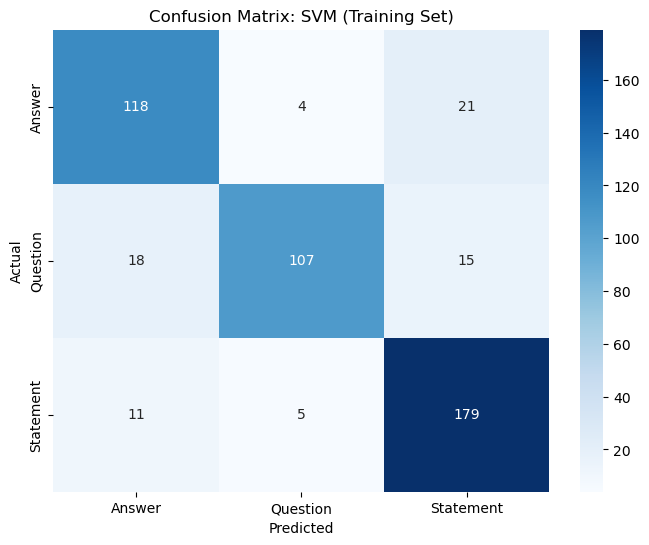

Confusion Matrix for Test Set:


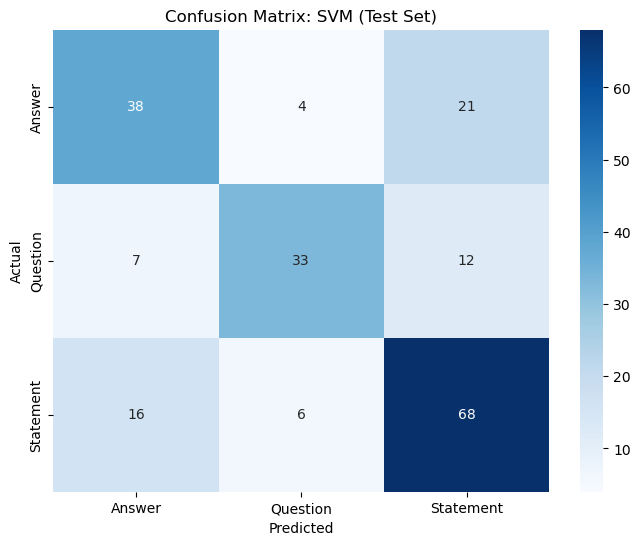

In [13]:


# Function to train and evaluate SVM with hyperparameter tuning (RandomizedSearchCV)
def run_svm(X_train, X_test, y_train, y_test, label_encoder):
    # Define hyperparameter distribution for RandomizedSearchCV
    param_dist = {
        'C': np.logspace(-3, 3, 10),        # C values on a log scale
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Adding specific gamma values to search
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'degree': [2, 3, 4],                # Only applicable for 'poly' kernel
        'coef0': [0, 0.1, 0.5, 1]           # Only applicable for 'poly' and 'sigmoid' kernels
    }

    # Initialize SVM and RandomizedSearchCV for hyperparameter tuning
    model = SVC()
    random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    
    # Train the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = random_search.best_estimator_
    
    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Best Hyperparameters found by RandomizedSearchCV:", random_search.best_params_)
    print("Results for SVM after Randomized Hyperparameter Tuning:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep)
    
    # Plot confusion matrix for the training set
    print("Confusion Matrix for Training Set:")
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "SVM (Training Set)")
    
    # Plot confusion matrix for the test set
    print("Confusion Matrix for Test Set:")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM (Test Set)")

# Call the updated function
run_svm(X_train, X_test, y_train, y_test, label_encoder)


Best Hyperparameters found by GridSearchCV: {'C': 1.0, 'coef0': 0.5, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
Results for SVM after GridSearch Hyperparameter Tuning:
Training Accuracy: 0.9749
Test Accuracy: 0.6878
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.60      0.78      0.68        63
    Question       0.73      0.63      0.68        52
   Statement       0.76      0.66      0.70        90

    accuracy                           0.69       205
   macro avg       0.70      0.69      0.69       205
weighted avg       0.70      0.69      0.69       205

Confusion Matrix for Training Set:


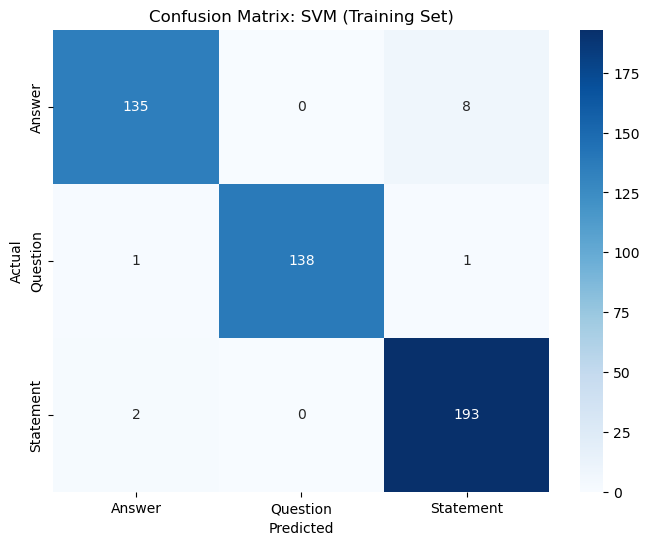

Confusion Matrix for Test Set:


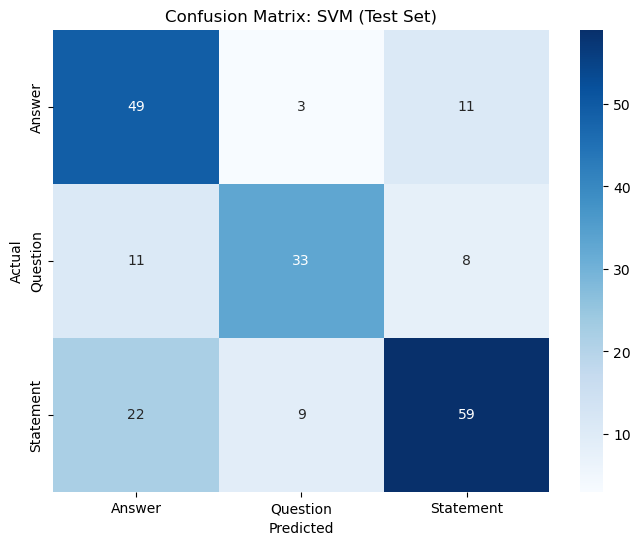

In [20]:


# Function to train and evaluate SVM with hyperparameter tuning (GridSearchCV)
def run_svm(X_train, X_test, y_train, y_test, label_encoder):
    # Define hyperparameter grid for GridSearchCV
    param_grid = {
        'C': np.logspace(-3, 3, 15),        # C values on a log scale, fewer values compared to RandomSearchCV for fine-tuning
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Gamma values to search
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],   # Different SVM kernels
        'degree': [2, 3, 4],                # Only applicable for 'poly' kernel
        'coef0': [0, 0.1, 0.5, 1]           # Only applicable for 'poly' and 'sigmoid' kernels
    }

    # Initialize SVM and GridSearchCV for hyperparameter tuning
    model = SVC()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = grid_search.best_estimator_
    
    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Best Hyperparameters found by GridSearchCV:", grid_search.best_params_)
    print("Results for SVM after GridSearch Hyperparameter Tuning:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep)
    
    # Plot confusion matrix for the training set
    print("Confusion Matrix for Training Set:")
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "SVM (Training Set)")
    
    # Plot confusion matrix for the test set
    print("Confusion Matrix for Test Set:")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM (Test Set)")

# Call the updated function
run_svm(X_train, X_test, y_train, y_test, label_encoder)


Results for Decision Tree:
Accuracy: 0.5659
Classification Report:
              precision    recall  f1-score   support

      Answer       0.46      0.51      0.48        63
    Question       0.57      0.60      0.58        52
   Statement       0.65      0.59      0.62        90

    accuracy                           0.57       205
   macro avg       0.56      0.56      0.56       205
weighted avg       0.57      0.57      0.57       205



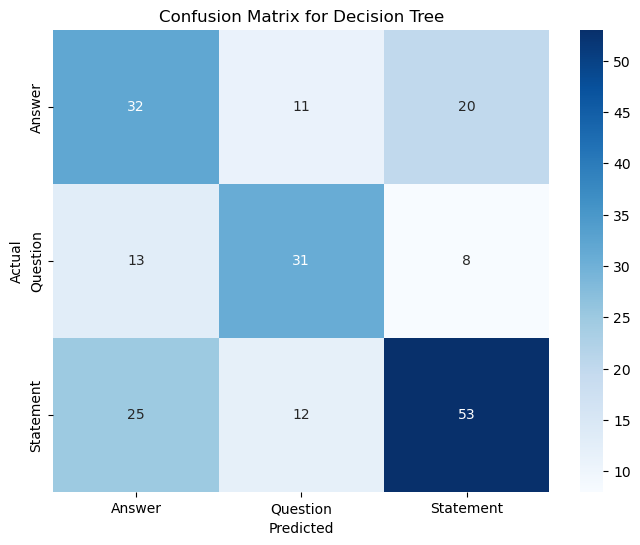

In [5]:
# Function to train and evaluate Decision Tree
def run_decision_tree(X_train, X_test, y_train, y_test, label_encoder):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    print("Results for Decision Tree:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    plot_confusion_matrix(y_test, y_pred, label_encoder, "Decision Tree")
run_decision_tree(X_train, X_test, y_train, y_test, label_encoder)

Results for Random Forest:
Accuracy: 0.6390
Classification Report:
              precision    recall  f1-score   support

      Answer       0.56      0.71      0.63        63
    Question       0.62      0.67      0.65        52
   Statement       0.74      0.57      0.64        90

    accuracy                           0.64       205
   macro avg       0.64      0.65      0.64       205
weighted avg       0.66      0.64      0.64       205



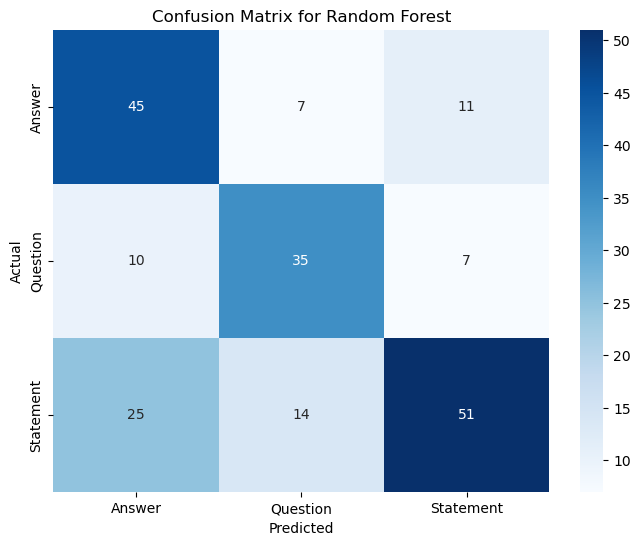

In [6]:
# Function to train and evaluate Random Forest
def run_random_forest(X_train, X_test, y_train, y_test, label_encoder):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    print("Results for Random Forest:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    plot_confusion_matrix(y_test, y_pred, label_encoder, "Random Forest")
run_random_forest(X_train, X_test, y_train, y_test, label_encoder)

Results for AdaBoost:
Accuracy: 0.5659
Classification Report:
              precision    recall  f1-score   support

      Answer       0.49      0.33      0.40        63
    Question       0.58      0.54      0.56        52
   Statement       0.59      0.74      0.66        90

    accuracy                           0.57       205
   macro avg       0.55      0.54      0.54       205
weighted avg       0.56      0.57      0.55       205



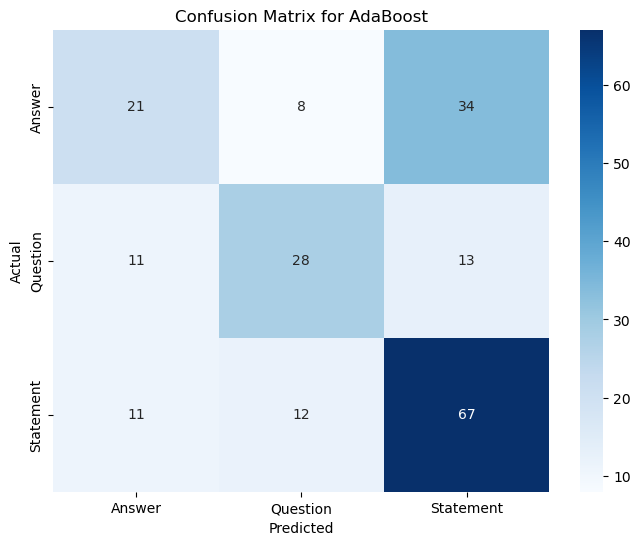

In [7]:
# Function to train and evaluate AdaBoost
def run_adaboost(X_train, X_test, y_train, y_test, label_encoder):
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    print("Results for AdaBoost:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    plot_confusion_matrix(y_test, y_pred, label_encoder, "AdaBoost")


run_adaboost(X_train, X_test, y_train, y_test, label_encoder)

Results for Naive Bayes:
Accuracy: 0.6634
Classification Report:
              precision    recall  f1-score   support

      Answer       0.65      0.63      0.64        63
    Question       0.63      0.62      0.62        52
   Statement       0.70      0.71      0.70        90

    accuracy                           0.66       205
   macro avg       0.66      0.65      0.65       205
weighted avg       0.66      0.66      0.66       205



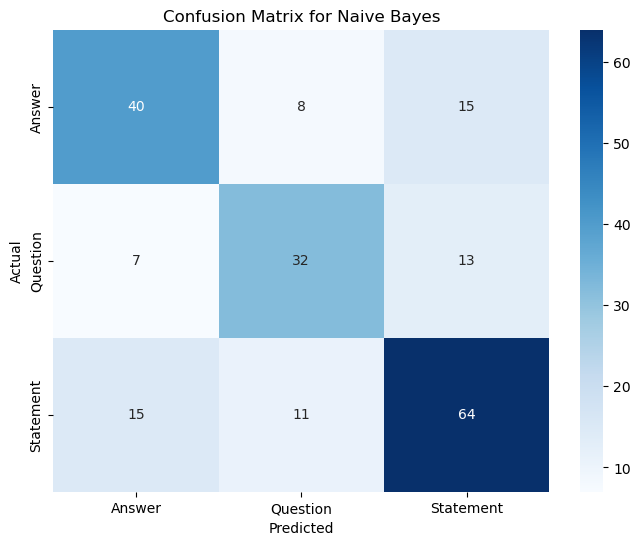

In [8]:
# Function to train and evaluate Naive Bayes
def run_naive_bayes(X_train, X_test, y_train, y_test, label_encoder):
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    print("Results for Naive Bayes:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    plot_confusion_matrix(y_test, y_pred, label_encoder, "Naive Bayes")
    
run_naive_bayes(X_train, X_test, y_train, y_test, label_encoder)

Results for XGBoost:
Accuracy: 0.6439
Classification Report:
              precision    recall  f1-score   support

      Answer       0.56      0.62      0.59        63
    Question       0.71      0.69      0.70        52
   Statement       0.68      0.63      0.66        90

    accuracy                           0.64       205
   macro avg       0.65      0.65      0.65       205
weighted avg       0.65      0.64      0.65       205



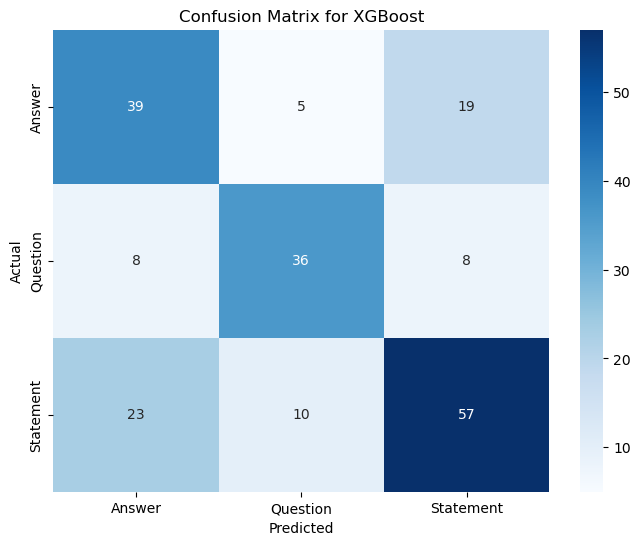

In [9]:
# Function to train and evaluate XGBoost
def run_xgboost(X_train, X_test, y_train, y_test, label_encoder):
    model = xgb.XGBClassifier(eval_metric='mlogloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    print("Results for XGBoost:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    plot_confusion_matrix(y_test, y_pred, label_encoder, "XGBoost")
run_xgboost(X_train, X_test, y_train, y_test, label_encoder)

Results for KNN:
Accuracy: 0.5902
Classification Report:
              precision    recall  f1-score   support

      Answer       0.46      0.76      0.57        63
    Question       0.70      0.44      0.54        52
   Statement       0.75      0.56      0.64        90

    accuracy                           0.59       205
   macro avg       0.63      0.59      0.58       205
weighted avg       0.64      0.59      0.59       205



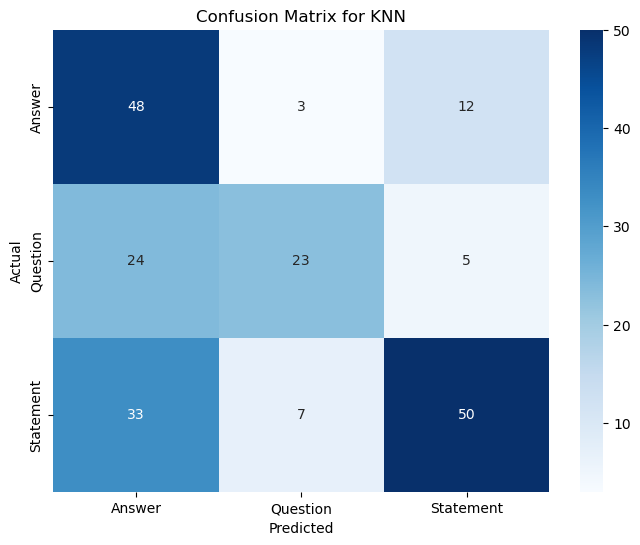

In [10]:
def run_knn(X_train, X_test, y_train, y_test, label_encoder):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    print("Results for KNN:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    plot_confusion_matrix(y_test, y_pred, label_encoder, "KNN")
run_knn(X_train, X_test, y_train, y_test, label_encoder)